# PNG to GeoTIFF Conversion Pipeline

## Summary

In this chapter we build a workflow for converting our image data to geotiff files usable by geosam.\
TODO: elaborate

In [5]:
import numpy as np
import os.path
import scipy.io
from PIL import Image as im
import matplotlib.pyplot as plt
import pyproj
import math
from osgeo import gdal
from osgeo import osr

In [9]:
# We only use this running locally, since this data file is too big for Github.
# airborne_data_path = "../data/AirborneData.mat"
# If you are running on colab, use this instead:
# airborne_data_path = "elwha_dataset_realignment/book/data/AirborneDataMini.mat"
# For just using the mini dataset locally:
airborne_data_path = "../data/AirborneDataMini.mat"

assert os.path.exists(airborne_data_path)

Loading the massive `mat` file takes a while so we place it in its own code cell.

In [10]:
airborne_data = scipy.io.loadmat(airborne_data_path)

Let's take a look at the keys.

In [11]:
airborne_keys = list(airborne_data.keys())
print(airborne_keys)

['__header__', '__version__', '__globals__', 'imageRGB', 'imageIR', 'northings', 'eastings', 'altitude']


In [12]:
class color:
    GREEN = "\033[92m"
    YELLOW = "\033[93m"
    RED = "\033[91m"
    BOLD = "\033[1m"
    END = "\033[0m"

def peekAtData(index: int):
    key = airborne_keys[index]
    data = airborne_data[key]

    print(color.BOLD + ">", key + color.END)
    print(type(data))
    print(data.shape, "\n")

    return data

In [21]:
northings_data = peekAtData(5)
eastings_data = peekAtData(6)
altitude_data = peekAtData(7)

> northings
<class 'numpy.ndarray'>
(406, 1) 

> eastings
<class 'numpy.ndarray'>
(406, 1) 

> altitude
<class 'numpy.ndarray'>
(406, 1) 



In [115]:
# xt_data = peekAtData(9)
# yt_data = peekAtData(10)
# # zt_data = peekAtData(11)

# show_index = 10
# xt_image_data = im.fromarray(np.rot90(xt_data[:,:,show_index], -1, (0, 1)))
# yt_image_data = im.fromarray(np.rot90(yt_data[:,:,show_index], -1, (0, 1)))
# # zt_image_data = im.fromarray(np.rot90(zt_data[:,show_index], -1, (0, 1)))

# figure, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)
# ax0.imshow(xt_image_data)
# ax1.imshow(yt_image_data)
# # ax2.imshow(zt_image_data)
# ax0.axis("off")
# ax1.axis("off")
# # ax2.axis("off")

In [15]:
rgb_data = peekAtData(3)
ir_data = peekAtData(4)

> imageRGB
<class 'numpy.ndarray'>
(640, 480, 25, 3) 

> imageIR
<class 'numpy.ndarray'>
(480, 640, 25) 



In [17]:
def convert_utm_to_latlon(easting, northing, zone_number, northern_hemisphere=True):
    """
    Convert UTM coordinates (easting, northing) to latitude and longitude.

    Args:
        easting (float): Easting coordinate in meters.
        northing (float): Northing coordinate in meters.
        zone_number (int): UTM zone number (e.g., 33 for UTM Zone 33N).
        northern_hemisphere (bool): True for northern hemisphere, False for southern.

    Returns:
        (float, float): Latitude and Longitude in decimal degrees.
    """
    # Define the UTM projection based on the given zone number and hemisphere
    utm_crs = f"+proj=utm +zone={zone_number} {'+north' if northern_hemisphere else '+south'} +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
    
    # Create a transformer from UTM to WGS84 (latitude and longitude)
    transformer = pyproj.Transformer.from_crs(utm_crs, "+proj=longlat +datum=WGS84", always_xy=True)
    
    # Perform the transformation
    lon, lat = transformer.transform(easting, northing)

    return lat, lon

In [46]:
def calculate_image_corners(image_width, image_height, camera_latitude, camera_longitude, camera_altitude):
    # Earth's radius in meters
    earth_radius = 6371000  # approximate value for Earth's mean radius

    # Convert camera latitude and longitude to radians
    camera_lat_rad = math.radians(camera_latitude)
    camera_lon_rad = math.radians(camera_longitude)

    # Calculate the distance from the camera to the Earth's center
    distance_to_center = earth_radius + camera_altitude

    # Calculate the horizontal and vertical field of view angles
    horizontal_fov = 2.0 * math.atan((image_width / 2.0) / distance_to_center)
    vertical_fov = 2.0 * math.atan((image_height / 2.0) / distance_to_center)

    # Calculate the half-width and half-height of the image in meters
    half_width = distance_to_center * math.tan(horizontal_fov / 2.0)
    half_height = distance_to_center * math.tan(vertical_fov / 2.0)

    # Calculate the coordinates of each corner
    top_left_lat = math.degrees(camera_lat_rad + half_height / earth_radius)
    top_left_lon = math.degrees(camera_lon_rad - half_width / earth_radius)

    # top_right_lat = math.degrees(camera_lat_rad + half_height / earth_radius)
    top_right_lon = math.degrees(camera_lon_rad + half_width / earth_radius)

    bottom_left_lat = math.degrees(camera_lat_rad - half_height / earth_radius)
    # bottom_left_lon = math.degrees(camera_lon_rad - half_width / earth_radius)

    # bottom_right_lat = math.degrees(camera_lat_rad - half_height / earth_radius)
    # bottom_right_lon = math.degrees(camera_lon_rad + half_width / earth_radius)

    min_lat = min(top_left_lat, bottom_left_lat)
    min_lon = min(top_left_lon, top_right_lon)
    max_lat = max(top_left_lat, bottom_left_lat)
    max_lon = max(top_left_lon, top_right_lon)

    return [min_lat, min_lon, max_lat, max_lon]

In [32]:
# Example usage, testing Seattle
easting = 549967.97
northing = 5272948.10
zone_number = 10 # UTM zone for west coast is 10
northern_hemisphere = True

latitude, longitude = convert_utm_to_latlon(easting, northing, zone_number, northern_hemisphere)
print(f"Latitude: {latitude}, Longitude: {longitude}")

Latitude: 47.60801296515217, Longitude: -122.33516697208582


<class 'numpy.ndarray'> (640, 480, 3)


(-0.5, 479.5, 639.5, -0.5)

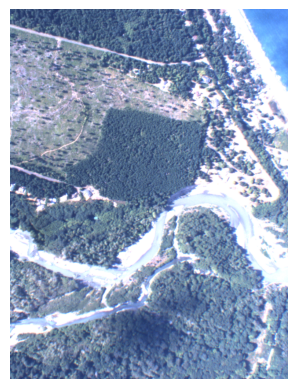

In [33]:
image_index = 0
image = rgb_data[:,:,image_index]
image_size = image.shape[:2]

print(type(image), image.shape)
plt.imshow(image)
plt.axis("off")

In [47]:
#  Setting the geographic transform

easting = eastings_data[image_index]
northing = northings_data[image_index]
zone_number = 10 # UTM zone for west coast is 10
northern_hemisphere = True

lat_center, lon_center = convert_utm_to_latlon(easting, northing, zone_number, northern_hemisphere)
print(f"Latitude: {lat_center}, Longitude: {lon_center}") # If we test on https://www.gps-coordinates.net/ these values are accurate

# Example usage:
image_height = image_size[0]
image_width = image_size[1]
camera_altitude = altitude_data[image_index]

corners = calculate_image_corners(image_width, image_height, lat_center[0], lon_center[0], camera_altitude[0])
print(corners)

Latitude: [48.13767712], Longitude: [-123.56505045]
[48.13479929469142, -123.56720882493316, 48.1405549529693, -123.56289208122476]


In [48]:
# create each channel
r_pixels = image[:,:,0]
g_pixels = image[:,:,1]
b_pixels = image[:,:,2]

# set geotransform
nx = image_size[0]
ny = image_size[1]
# xmin, ymin, xmax, ymax = [min(lon), min(lat), max(lon), max(lat)]
xmin, ymin, xmax, ymax = corners
xres = (xmax - xmin) / float(nx)
yres = (ymax - ymin) / float(ny)
geotransform = (xmin, xres, 0, ymax, 0, -yres)

In [49]:
# create the 3-band raster file
tif_image = "myGeoTIFF.tif"
dst_ds = gdal.GetDriverByName("GTiff").Create(tif_image, ny, nx, 3, gdal.GDT_Byte)

dst_ds.SetGeoTransform(geotransform)    # specify coords
srs = osr.SpatialReference()            # establish encoding
srs.ImportFromEPSG(3857)                # WGS84 lat/long
dst_ds.SetProjection(srs.ExportToWkt()) # export coords to file
dst_ds.GetRasterBand(1).WriteArray(r_pixels)   # write r-band to the raster
dst_ds.GetRasterBand(2).WriteArray(g_pixels)   # write g-band to the raster
dst_ds.GetRasterBand(3).WriteArray(b_pixels)   # write b-band to the raster
dst_ds.FlushCache()                     # write to disk
dst_ds = None

c:\Users\stefa\anaconda3\envs\elwha_env\lib\site-packages\osgeo\gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


EPSG:3857 BoundingBox(left=48.13479929469142, bottom=-123.56864773950262, right=48.139116038399834, top=-123.56289208122476)


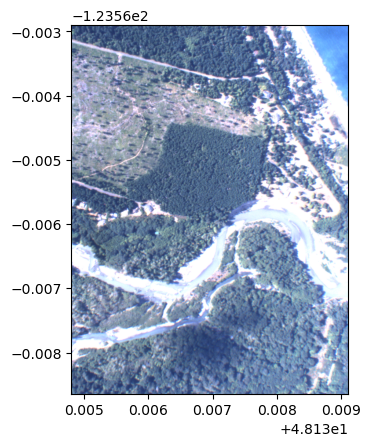

In [74]:
import rasterio
from rasterio.plot import show

with rasterio.open(tif_image) as ds:
    print(ds.crs, ds.bounds)
    show(ds.read([1, 2, 3]), transform=ds.profile["transform"])

In [51]:
from samgeo import SamGeo
sam = SamGeo(
    model_type="vit_h",
    automatic=False,
    sam_kwargs=None,
)

In [52]:
sam.set_image(tif_image)

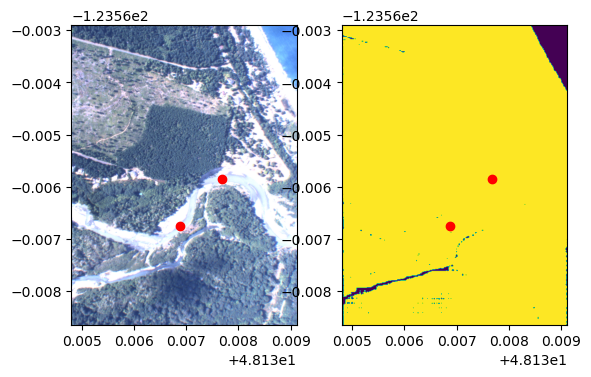

In [121]:
import geopandas
from shapely.geometry import Point

predict_coords = [
    [48.137677123830365, -123.56585045307897],
    [48.136877123830365, -123.56675045307897],
]

prediction_mask = "mask1.tif"
sam.predict(predict_coords, point_labels=1, point_crs="EPSG:3857", output=prediction_mask)

point_coords = [Point(coord) for coord in predict_coords]
gdf = geopandas.GeoDataFrame([1, 2], geometry=point_coords, crs=3857)
# gdf = gdf.set_crs("epsg:3857")

figure, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)

with rasterio.open(tif_image) as src:
    # transform rasterio plot to real world coords
    extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
    ax0 = rasterio.plot.show(src, extent=extent, ax=ax0)

    gdf.plot(ax=ax0, color="red")

with rasterio.open(prediction_mask) as ds:
    ax1 = rasterio.plot.show(ds, transform=ds.profile["transform"], ax=ax1)
    gdf.plot(ax=ax1, color="red")